<a href="https://colab.research.google.com/github/ED1-WELL/wheeled_pupper_collab/blob/main/Updated_wheeled_pupper_Jan_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hello!**
Welcome to the Pupper training grounds.

Use this colab to train a RL controller (a "policy") for your Pupper!

# Instructions

## Before running this colab
1. Make a Weights and Biases account and get your API Key

## Running this colab
1. Change GPU to A100 or L4 by clicking "Runtime" then "Change runtime type"
2. Run this colab by clicking "Run all" or running each cell individually.
3. Pay attention to the cell below "Log in to Weights and Biases" which will prompt you for your API key.

## Going deeper
1. Increase the training time by setting the "training_config.ppo.num_timesteps" value to 1 billion and "training_config.ppo.learning_rate" to 1e-5. Training longer usually leads to better policies (higher reward), which are more stable, agile, etc. After changing a setting, make sure to "Run all" again so that config values are properly propagated.
2. Add obstacles to the training environment by setting the "training_config.n_obstacles" variable. 5 to 100 is a reasonable range. I tend to use 20.
3. Train a backflip! This is the wild west - it's all on you! See mujoco playground for some ideas how to implement this

## Deploying to the robot
See https://pupper-v3-documentation.readthedocs.io/en/latest/development/modifying_code.html

## Trouble-shooting
Cannot interrupt training run: Click "Runtime" -> "Restart session and run all"

Get help on our Discord https://discord.com/invite/qbmaU8NmP2

# Log in to Weights and Biases

I recommend you use colab "secrets" (see key icon on the left) and add a secret "wandb_key" with your Weights & Biases API key. If you choose not to, you can enter the API key in the cell with wandb.login when it prompts you.

In [1]:
# Prompt user for run name
print("Please enter a name for this run in the box below.")
run_name = input("Run Name (press Enter for auto-generated): ").strip()
if not run_name:
    run_name = None

Please enter a name for this run in the box below.
Run Name (press Enter for auto-generated): default_harsher_tune


In [2]:
from google.colab import userdata
try:
  wandb_key = userdata.get('wandb_key')
except userdata.SecretNotFoundError:
  wandb_key = 'fe8596894517233dd099cb1bd8dfe76f9528b126'

In [3]:
!pip install -q wandb
import wandb
wandb.login(key=wandb_key if wandb_key else None)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: edretzka (edretzka-university-of-wisconsin-madison) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Install dependencies

In [4]:
!pip install mujoco==3.2.7 mujoco-mjx==3.2.7 brax==0.12.1 flax==0.10.2 orbax==0.1.9
!pip install black[jupyter] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 59.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 740.4/740.4 kB 68.2 MB/s eta 0:00:00
  Created wheel for orbax: filename=orbax-0.1.

In [5]:
import os
# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [6]:
# Clean up incompatible versions
!pip uninstall -y jax jaxlib orbax-checkpoint

# Install JAX 0.4.30 and a compatible orbax-checkpoint
!pip install "jax[cuda12]==0.4.30" "jaxlib==0.4.30" orbax-checkpoint -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Found existing installation: jax 0.7.2
Uninstalling jax-0.7.2:
  Successfully uninstalled jax-0.7.2
Found existing installation: jaxlib 0.7.2
Uninstalling jaxlib-0.7.2:
  Successfully uninstalled jaxlib-0.7.2
Found existing installation: orbax-checkpoint 0.11.32
Uninstalling orbax-checkpoint-0.11.32:
  Successfully uninstalled orbax-checkpoint-0.11.32
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
INFO: pip is looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of orbax-checkpoint to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━

In [7]:
#@title Check if MuJoCo installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [8]:
#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:


In [9]:
#@title Import MuJoCo, MJX, and Brax


from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Config

## pupperv3-mjx repo config

In [10]:
pupperv3_mjx_config = config_dict.ConfigDict()
pupperv3_mjx_config.branch = "Ethan_test"

In [11]:
!rm -rf pupperv3_mjx
!git clone https://github.com/ED1-WELL/mjx_Wheels_pupperv3.git -b {pupperv3_mjx_config.branch} #-b {pupperv3_mjx_config.branch} https://github.com/Nate711/pupperv3-mjx.git
!mv mjx_Wheels_pupperv3 pupperv3_mjx
!cd pupperv3_mjx && git pull && pip install -q .

Cloning into 'mjx_Wheels_pupperv3'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 87 (delta 38), reused 73 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 994.25 KiB | 27.62 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Already up to date.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.3/354.3 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 38.2 MB/s eta 0:00:00


## Simulation Config

In [12]:
# Pupper model configuration
simulation_config = config_dict.ConfigDict()
simulation_config.model_repo = 'https://github.com/ED1-WELL/description_Wheels_pupperv3.git' #'https://github.com/g-levine/pupper_v3_description'
simulation_config.model_branch = 'Ethan_test' #'master'

!rm -rf pupper_v3_description
!git clone {simulation_config.model_repo} -b {simulation_config.model_branch}
!cd pupper_v3_description && git pull

Cloning into 'description_Wheels_pupperv3'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 199 (delta 124), reused 155 (delta 81), pack-reused 0 (from 0)
Receiving objects: 100% (199/199), 11.70 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (124/124), done.
/bin/bash: line 1: cd: pupper_v3_description: No such file or directory


In [13]:
# Select model
#simulation_config.original_model_path = 'pupper_v3_description/description/mujoco_xml/pupper_v3_complete.mjx.position.no_body.self_collision.two_iterations.xml' # 3Nm max
simulation_config.original_model_path = 'description_Wheels_pupperv3/description/mujoco_xml/Wheel_pupper.xml'

simulation_config.model_xml = epath.Path(simulation_config.original_model_path).read_text()
simulation_config.model_path = "description_Wheels_pupperv3/description/mujoco_xml/model_with_obstacles.xml"

# Model body names
# simulation_config.upper_leg_body_names = ["leg_front_r_2", "leg_front_l_2", "leg_back_r_2", "leg_back_l_2"]
# simulation_config.lower_leg_body_names = ["leg_front_r_3", "leg_front_l_3", "leg_back_r_3", "leg_back_l_3"]
simulation_config.upper_leg_body_names = ["leg_front_r_2", "leg_front_l_2", "leg_back_r_2", "leg_back_l_2"]
simulation_config.lower_leg_body_names = ["Wheel_FR","Wheel_FL","Wheel_BR","Wheel_BL"]
simulation_config.foot_site_names = [
    "leg_front_r_3_foot_site",
    "leg_front_l_3_foot_site",
    "leg_back_r_3_foot_site",
    "leg_back_l_3_foot_site",
]
simulation_config.torso_name = "base_link"

# Foot radius
simulation_config.foot_radius = 0.02

# Collision detection
simulation_config.max_contact_points = 20 # Default: 8. 20 recommended for non-flat terrain.
simulation_config.max_geom_pairs = 20 # Default: 8. 20 recommended for non-flat terrain.

# Joint limits
sys_temp = mjcf.load(simulation_config.original_model_path)
joint_upper_limits = sys_temp.jnt_range[1:, 1]
joint_lower_limits = sys_temp.jnt_range[1:, 0]
simulation_config.joint_upper_limits = np.array(joint_upper_limits).tolist()
simulation_config.joint_lower_limits = np.array(joint_lower_limits).tolist()

# Physics timestep
simulation_config.physics_dt = 0.004 # Physics dt [s]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Training Config

In [14]:
from pupperv3_mjx import domain_randomization

import importlib

importlib.reload(domain_randomization)

training_config = config_dict.ConfigDict()

# Checkpoint
# Will use checkpoint from W&B run "blah-blah-{checkpoint_run_number}"
training_config.checkpoint_run_number = None

# Environment timestep
training_config.environment_dt = 0.02

# PPO params
training_config.ppo = config_dict.ConfigDict()
training_config.ppo.num_timesteps = 300_000_000   # Default: 300M. Set to 1B for better policy.
training_config.ppo.episode_length = 500         # Default: 500
training_config.ppo.num_evals = 11                # Default: 10
training_config.ppo.reward_scaling = 1            # Default: 1
training_config.ppo.normalize_observations = True # Default: True
training_config.ppo.action_repeat = 1             # Default: 1
training_config.ppo.unroll_length = 20            # Default: 20
training_config.ppo.num_minibatches = 32          # Default: 32
training_config.ppo.num_updates_per_batch = 4     # Default: 4
training_config.ppo.discounting = 0.97            # Default: 0.97
training_config.ppo.learning_rate = 3.0e-4        # Default: 3.0e-4. Set to 3e-5 if using >300M timesteps.
training_config.ppo.entropy_cost = 1e-2           # Default: 1e-2
training_config.ppo.num_envs = 8192               # Default: 8192
training_config.ppo.batch_size = 256              # Default: 256

# Command sampling
training_config.resample_velocity_step = training_config.ppo.episode_length // 2
training_config.lin_vel_x_range = [-0.75, 0.75]  # min max [m/s]. Default: [-0.75, 0.75]
training_config.lin_vel_y_range = [-0.5, 0.5]  # min max [m/s]. Default: [-0.5, 0.5]
training_config.ang_vel_yaw_range = [-2.0, 2.0]  # min max [rad/s]. Default: [-2.0, 2.0]
training_config.zero_command_probability = 0.02
training_config.stand_still_command_threshold = 0.05

# Orientation command sampling in degrees
training_config.maximum_pitch_command = 0.0 # [radians]
training_config.maximum_roll_command = 0.0 # [radians]

# Desired body orientation
training_config.desired_world_z_in_body_frame = (0.0, 0.0, 1.0) # Default: (0.0, 0.0, 1.0)

# Termination
# NOTE: without a body collision geometry, can't train recovery policy
training_config.terminal_body_z = 0.05  # Episode ends if body center goes below this height [m] Default: 0.10 m
training_config.terminal_body_angle = 0.70  # Episode ends if body angle relative to vertical is more than this. Default: 0.52 rad (30 deg)
training_config.early_termination_step_threshold = training_config.ppo.episode_length // 2 # Default: 500

# Joint PD overrides
training_config.dof_damping = 0.25  # Joint damping [Nm / (rad/s)] Default: 0.25
training_config.position_control_kp = 5.0  # Joint stiffness [Nm / rad] Default: 5.0

# Default joint angles
training_config.default_pose = jp.array(
    [0.26, 0.0, -0.52, -0.26, 0.0, 0.52, 0.26, 0.0, -0.52, -0.26, 0.0, 0.52]
)

# 3 legs (BL up)
# training_config.default_pose = jp.array(
#     [0.26, 0.0, -0.52, -0.26, 0.0, 0.52, 0.26, 0.0, -0.52, -0.26, 0.0, -0.6]
# )

# Desired abduction angles
training_config.desired_abduction_angles = jp.array(
    [0.0, 0.0, 0.0, 0.0] #[-0.2, 0.2, -0.2, 0.2]
)

# Height field
## Type of height field
training_config.height_field_random = False
training_config.height_field_steps = False
### Steps type params
training_config.height_field_step_size = 4
## General height field settings
training_config.height_field_grid_size = 256
training_config.height_field_group = "0"
training_config.height_field_radius_x = 10.0 # [m]
training_config.height_field_radius_y = 10.0 # [m]
training_config.height_field_elevation_z = 0.02 # [m]
training_config.height_field_base_z = 0.2 # [m]

# Domain randomization
## Perturbations
training_config.kick_probability = 0.04        # Kick the robot with this probability. Default: 0.04
training_config.kick_vel = 0.10               # Change the torso velocity by up to this much in x and y direction [m/s] Default: 0.1
training_config.angular_velocity_noise = 0.1  # Default: 0.1 [rad/s]
training_config.gravity_noise = 0.05            # Default: 0.05 [u]
training_config.motor_angle_noise = 0.05        # Default: 0.05 [rad]
training_config.last_action_noise = 0.01       # Default: 0.01 [rad]

## Motors
training_config.position_control_kp_multiplier_range = (0.6, 1.1)
training_config.position_control_kd_multiplier_range = (0.8, 1.5)

## Starting position
training_config.start_position_config = domain_randomization.StartPositionRandomization(
    x_min=-2.0, x_max=2.0, y_min=-2.0, y_max=2.0, z_min=0.15, z_max=0.20
)

## Latency distribution
# Action latency
# 0 latency with 20% prob, 1 timestep latency with 80% prob
training_config.latency_distribution = jp.array([0.2, 0.8])

# IMU latency
# 0 latency with 50% prob, 1 timestep latency with 50% prob
training_config.imu_latency_distribution = jp.array([0.5, 0.5])

## Body CoM
training_config.body_com_x_shift_range = (-0.02, 0.03) # Default: -0.02, 0.02
training_config.body_com_y_shift_range = (-0.005, 0.005)
training_config.body_com_z_shift_range = (-0.005, 0.005)

## Mass and inertia randomization for all bodies
training_config.body_mass_scale_range = (0.9, 1.3)
training_config.body_inertia_scale_range = (0.9, 1.3)

## Friction
training_config.friction_range = (0.6, 1.4)

# Obstacles
# Set to ~20 for a policy that can go over obstacles.
# Rather than train a policy on obstacles from scratch, it is best to fine-tune
# a policy trained on flat ground.
# Set training_config.checkpoint_run_number above to fine-tune that policy (downloads weights and biases)
training_config.n_obstacles = 0 #
training_config.obstacle_x_range = (-3.0, 3.0)  # [m]
training_config.obstacle_y_range = (-3.0, 3.0)  # [m]
training_config.obstacle_height = 0.04  # [m]
training_config.obstacle_length = 2.0  # [m]

In [15]:
!rm -rf pupperv3_mjx
!git clone https://github.com/ED1-WELL/mjx_Wheels_pupperv3.git -b {pupperv3_mjx_config.branch} #-b {pupperv3_mjx_config.branch} https://github.com/Nate711/pupperv3-mjx.git
!mv pupperv3-mjx pupperv3_mjx
!cd pupperv3_mjx && git pull && pip install -q .

Cloning into 'mjx_Wheels_pupperv3'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 87 (delta 38), reused 73 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (87/87), 994.25 KiB | 27.62 MiB/s, done.
Resolving deltas: 100% (38/38), done.
mv: cannot stat 'pupperv3-mjx': No such file or directory
/bin/bash: line 1: cd: pupperv3_mjx: No such file or directory


In [16]:
!rm -rf pupperv3_mjx
!git clone https://github.com/ED1-WELL/mjx_Wheels_pupperv3.git -b {pupperv3_mjx_config.branch} #-b {pupperv3_mjx_config.branch} https://github.com/Nate711/pupperv3-mjx.git
!mv pupperv3-mjx pupperv3_mjx
!cd pupperv3_mjx && git pull && pip install -q .

fatal: destination path 'mjx_Wheels_pupperv3' already exists and is not an empty directory.
mv: cannot stat 'pupperv3-mjx': No such file or directory
/bin/bash: line 1: cd: pupperv3_mjx: No such file or directory


## Policy config

In [17]:
policy_config = config_dict.ConfigDict()

policy_config.use_imu = True # Whether to use IMU in policy. Default: True

policy_config.observation_history = 4  # number of stacked observations to give the policy

# 4 legs
policy_config.action_scale = 0.75  # Default 0.75

# 3 legs (BL up)
# policy_config.action_scale = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.1] # no back left knee or front knee

policy_config.hidden_layer_sizes = (256, 128, 128, 128)
# Default for locomotion is (256, 128, 128, 128)

# Can change value network with
# policy_config.value_hidden_layer_sizes
# The network defaults to (256, 256, 256, 256, 256)
# https://github.com/google/brax/blob/01ca8cafd410a7b623e01628fae65e07065dcb0d/brax/training/agents/ppo/networks.py#L72

# RTNeural supports relu, tanh, sigmoid (not great), softmax, elu, prelu
# Swish was really good in terms of training but not supported in RTNeural rn
policy_config.activation = "elu"

## Reward config

In [18]:
# reward_config = config_dict.ConfigDict()
# reward_config.rewards = config_dict.ConfigDict()
# reward_config.rewards.scales = config_dict.ConfigDict()

# # Track linear velocity
# reward_config.rewards.scales.tracking_lin_vel = 6

# # Track the angular velocity along z-axis, i.e. yaw rate.
# reward_config.rewards.scales.tracking_ang_vel = 5

# # Track the given body orientation (desired world z axis in body frame)
# # Not working right nowkick
# reward_config.rewards.scales.tracking_orientation = 0.5

# # Below are regularization terms, we roughly divide the
# # terms to base state regularizations, joint
# # regularizations, and other behavior regularizations.
# # Penalize the base velocity in z direction, L2 penalty.
# reward_config.rewards.scales.lin_vel_z = -0.5

# # Penalize the base roll and pitch rate. L2 penalty.
# reward_config.rewards.scales.ang_vel_xy = -0.05

# # Penalize non-zero roll and pitch angles. L2 penalty.
# reward_config.rewards.scales.orientation = -0.5

# # L2 regularization of joint torques, sum(|tau|^2).
# reward_config.rewards.scales.torques = -0.0001

# # L2 regularization of joint accelerations sum(|qdd|^2)
# reward_config.rewards.scales.joint_acceleration = -1e-7

# # L1 regularization of mechanical work, |v * tau|.
# reward_config.rewards.scales.mechanical_work = 0

# # Penalize the change in the action and encourage smooth
# # actions. L1 regularization |action - last_action|^2
# reward_config.rewards.scales.action_rate = -0.01

# # Encourage long swing steps. However, it does not
# # encourage high clearances.
# reward_config.rewards.scales.feet_air_time = 0

# # Encourage joints at default position at zero command, L1 regularization
# # |q - q_default|.
# reward_config.rewards.scales.stand_still = 0

# # Encourage zero joint velocity at zero command, L1 regularization
# # |q_dot|.
# # Activates when norm(command) < stand_still_command_threshold
# # Commands below this threshold are sampled with probability zero_command_probability
# reward_config.rewards.scales.stand_still_joint_velocity = 0

# # Encourage zero abduction angle so legs don't spread so far out
# # L2 loss on ||abduction_motors - desired||^2
# reward_config.rewards.scales.abduction_angle = -4

# # Early termination penalty.
# reward_config.rewards.scales.termination = -100

# # Penalizing foot slipping on the ground.
# reward_config.rewards.scales.foot_slip = 0

# # Penalize knees hitting the ground
# reward_config.rewards.scales.knee_collision = -1.0

# # Penalize body hitting ground
# reward_config.rewards.scales.body_collision = -2.0

# # Penalize wheels lifting up
# reward_config.rewards.scales.wheels_on_ground = -150.0

# # Tracking reward = exp(-error^2/sigma).
# reward_config.rewards.tracking_sigma = 0.25

reward_config = config_dict.ConfigDict()
reward_config.rewards = config_dict.ConfigDict()
reward_config.rewards.scales = config_dict.ConfigDict()

# Track linear velocity
reward_config.rewards.scales.tracking_lin_vel = 2

# Track the angular velocity along z-axis, i.e. yaw rate.
reward_config.rewards.scales.tracking_ang_vel = 1.5

# Track the given body orientation (desired world z axis in body frame)
# Not working right nowkick
reward_config.rewards.scales.tracking_orientation = 0.5 # 0.5 default

# Below are regularization terms, we roughly divide the
# terms to base state regularizations, joint
# regularizations, and other behavior regularizations.
# Penalize the base velocity in z direction, L2 penalty.
reward_config.rewards.scales.lin_vel_z = -0.1  # -2.0

# Penalize the base roll and pitch rate. L2 penalty.
reward_config.rewards.scales.ang_vel_xy = -0.002  # -0.05,

# Penalize non-zero roll and pitch angles. L2 penalty.
reward_config.rewards.scales.orientation = -0.0  # -5.0

# L2 regularization of joint torques, sum(|tau|^2).
reward_config.rewards.scales.torques = -0.025  # Default -0.025

# L2 regularization of joint accelerations sum(|qdd|^2)
reward_config.rewards.scales.joint_acceleration = -1e-6 # [rad/s/s] Default: -1e-6

# L1 regularization of mechanical work, |v * tau|.
reward_config.rewards.scales.mechanical_work = 0  # -0.01,

# Penalize the change in the action and encourage smooth
# actions. L1 regularization |action - last_action|^2
reward_config.rewards.scales.action_rate = -0.1  # Default: -0.1 originally -0.01

# Encourage long swing steps. However, it does not
# encourage high clearances.
reward_config.rewards.scales.feet_air_time = 0 # 0.02  # originally 0.2

# Encourage joints at default position at zero command, L1 regularization
# |q - q_default|.
reward_config.rewards.scales.stand_still = -0.00  # -0.5

# Encourage zero joint velocity at zero command, L1 regularization
# |q_dot|.
# Activates when norm(command) < stand_still_command_threshold
# Commands below this threshold are sampled with probability zero_command_probability
reward_config.rewards.scales.stand_still_joint_velocity = -0.25  # -0.05 was not enough with 1%

# Encourage zero abduction angle so legs don't spread so far out
# L2 loss on ||abduction_motors - desired||^2
reward_config.rewards.scales.abduction_angle = -3 #-0.05 # -0.2 is too much, -0.02 produced weird turning, -0.005 is little

# Early termination penalty.
reward_config.rewards.scales.termination = -100.0

# Penalizing foot slipping on the ground.
reward_config.rewards.scales.foot_slip = 0

# Penalize knees hitting the ground
reward_config.rewards.scales.knee_collision = -10.0

# Penalize body hitting ground
reward_config.rewards.scales.body_collision = -0.5

# Penalize wheels lifting up
reward_config.rewards.scales.wheels_on_ground = -150.0

# Tracking reward = exp(-error^2/sigma).
reward_config.rewards.tracking_sigma = 0.25

##Export config

In [19]:
# Define the path to the subdirectory
export_config = config_dict.ConfigDict()
export_config.gdrive_save_dir = '/content/drive/MyDrive/pupper_policies'

## Github repo config

In [20]:
ls

description_Wheels_pupperv3/  mjx_Wheels_pupperv3/  sample_data/


In [21]:
import subprocess
def get_hash():
  return subprocess.check_output(['git', 'rev-parse', 'HEAD']).strip().decode('utf-8')

repo_config = config_dict.ConfigDict()
%cd /content/mjx_Wheels_pupperv3/
repo_config.pupperv3_mjx_hash = get_hash()
%cd /content/description_Wheels_pupperv3/
repo_config.pupper_v3_description_hash = get_hash()
%cd /content

/content/mjx_Wheels_pupperv3
/content/description_Wheels_pupperv3
/content


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Create aggregated config

In [22]:
temp_config = config_dict.ConfigDict()
temp_config.simulation = simulation_config
temp_config.training = training_config
temp_config.policy = policy_config
temp_config.reward = reward_config
temp_config.export = export_config
temp_config.repo = repo_config
temp_config.pupperv3_mjx = pupperv3_mjx_config

CONFIG = config_dict.FrozenConfigDict(temp_config)

# Prevent user from accidentally making changes to these configs which are not used
del temp_config, reward_config, policy_config, training_config, simulation_config, export_config

# Modify robot model

##Set contact options

In [23]:
import xml.etree.ElementTree as ET
xml_str = epath.Path(CONFIG.simulation.original_model_path).read_text()
tree = ET.ElementTree(ET.fromstring(xml_str))

In [24]:
from pupperv3_mjx import utils
import importlib
importlib.reload(utils)

tree = utils.set_mjx_custom_options(tree,
                                    max_contact_points=CONFIG.simulation.max_contact_points,
                                    max_geom_pairs=CONFIG.simulation.max_geom_pairs)

##Add obstacles

In [25]:
from pupperv3_mjx import obstacles
import importlib
importlib.reload(obstacles)

tree = obstacles.add_boxes_to_model(
    tree,
    n_boxes=CONFIG.training.n_obstacles,
    x_range=CONFIG.training.obstacle_x_range,
    y_range=CONFIG.training.obstacle_y_range,
    height=CONFIG.training.obstacle_height,
    # depth=CONFIG.training.obstacle_depth,
    length=CONFIG.training.obstacle_length
)

## Add height field ground

In [26]:
if CONFIG.training.height_field_random or CONFIG.training.height_field_steps:
  if CONFIG.training.height_field_random:
    # Height field with 8cm resolution
    noise = np.array(jax.random.uniform(jax.random.PRNGKey(0), (CONFIG.training.height_field_grid_size, CONFIG.training.height_field_grid_size)))

    # Height field with 1m resolution
    area_noise = jax.random.uniform(jax.random.PRNGKey(1),
    (1*int(CONFIG.training.height_field_grid_size//CONFIG.training.height_field_radius_x),
      1*int(CONFIG.training.height_field_grid_size//CONFIG.training.height_field_radius_y)))
    upscaled_area_noise = np.array(jax.image.resize(image=area_noise,
                                                  shape=(CONFIG.training.height_field_grid_size, CONFIG.training.height_field_grid_size),
                                                  method="nearest"))

    # Height field where
    scaled_noise = noise * upscaled_area_noise

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(noise, cmap='viridis')
    axs[0].set_title('High resolution base noise')
    axs[1].imshow(area_noise, cmap='viridis')
    axs[1].set_title('Low resolution noise to make discrete areas')
    axs[2].imshow(scaled_noise, cmap='viridis')
    axs[2].set_title('Final height field noise')

  if CONFIG.training.height_field_steps:
    # steps with 24cm width
    steps = jax.random.uniform(jax.random.PRNGKey(0),
                                (CONFIG.training.height_field_grid_size//CONFIG.training.height_field_step_size,
                                 CONFIG.training.height_field_grid_size//CONFIG.training.height_field_step_size))
    scaled_noise = np.array(jax.image.resize(image=steps,
                                    shape=(CONFIG.training.height_field_grid_size, CONFIG.training.height_field_grid_size),
                                    method="nearest"))

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].imshow(steps, cmap='viridis')
    axs[0].set_title('Low resolution step heights')
    axs[1].imshow(scaled_noise, cmap='viridis')
    axs[1].set_title('Final height field noise')


  root = tree.getroot()
  worldbody = root.find("worldbody")
  asset = root.find("asset")

  ET.SubElement(
      asset,
      "hfield",
      name="hfield_geom",
      # pos="0 0 0",
      nrow=f"{CONFIG.training.height_field_grid_size}",
      ncol=f"{CONFIG.training.height_field_grid_size}",
      elevation = ' '.join(scaled_noise.astype(str).flatten().tolist()),
      size=f"{CONFIG.training.height_field_radius_x} {CONFIG.training.height_field_radius_y} {CONFIG.training.height_field_elevation_z} {CONFIG.training.height_field_base_z}",
  )

  ET.SubElement(
      worldbody,
      "geom",
      name="hfield_floor",
      type="hfield",
      hfield="hfield_geom",
      # rgba="0.1 0.5 0.8 1",
      material="grid",
      conaffinity="1",
      contype="1",
      condim="3",
      group=CONFIG.training.height_field_group,
  )

## Write new model

In [27]:
with open(CONFIG.simulation.model_path,'w+') as file:
  tree.write(file, encoding='unicode')

# Benchmark pupper model

A100 GPU
* ~2M physics steps/s with 20 max collision pairs/pts and flat ground.


In [28]:
from mujoco.mjx import benchmark

In [29]:
# Using `with` syntax
# bfloat16: 2M
# tensorfloat32: 1.8M
# float32: 1.8M
# with jax.default_matmul_precision("bfloat16"):

# Using `jax.config.update` method
# high: 1.8M
# bfloat16: 2.05M
# tensorfloat32: 1.8M
# default: 2.05M
jax.config.update('jax_default_matmul_precision', 'high')
sys = mjcf.load(CONFIG.simulation.model_path)
jit_time, run_time, steps = benchmark(sys.mj_model, batch_size=CONFIG.training.ppo.num_envs)
physics_steps_per_sec = steps / run_time
print('Steps per sec: ', physics_steps_per_sec)

Steps per sec:  877614.3505457991


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


# Pupper V3 Env



## Create Pupper V3 Env


In [30]:
from pupperv3_mjx import environment
import importlib
importlib.reload(environment)

envs.register_environment('pupper', environment.PupperV3Env)

env_kwargs = dict(path=CONFIG.simulation.model_path,
                  action_scale=CONFIG.policy.action_scale,
                  observation_history=CONFIG.policy.observation_history,
                  joint_lower_limits=joint_lower_limits,
                  joint_upper_limits=joint_upper_limits,
                  dof_damping=CONFIG.training.dof_damping,
                  position_control_kp=CONFIG.training.position_control_kp,
                  foot_site_names=CONFIG.simulation.foot_site_names,
                  torso_name=CONFIG.simulation.torso_name,
                  upper_leg_body_names=CONFIG.simulation.upper_leg_body_names,
                  lower_leg_body_names=CONFIG.simulation.lower_leg_body_names,
                  resample_velocity_step=CONFIG.training.resample_velocity_step,
                  linear_velocity_x_range=CONFIG.training.lin_vel_x_range,
                  linear_velocity_y_range=CONFIG.training.lin_vel_y_range,
                  angular_velocity_range=CONFIG.training.ang_vel_yaw_range,
                  zero_command_probability=CONFIG.training.zero_command_probability,
                  stand_still_command_threshold=CONFIG.training.stand_still_command_threshold,
                  maximum_pitch_command=CONFIG.training.maximum_pitch_command,
                  maximum_roll_command=CONFIG.training.maximum_roll_command,
                  start_position_config=CONFIG.training.start_position_config,
                  default_pose=CONFIG.training.default_pose,
                  desired_abduction_angles=CONFIG.training.desired_abduction_angles,
                  reward_config=CONFIG.reward,
                  angular_velocity_noise=CONFIG.training.angular_velocity_noise,
                  gravity_noise=CONFIG.training.gravity_noise,
                  motor_angle_noise=CONFIG.training.motor_angle_noise,
                  last_action_noise=CONFIG.training.last_action_noise,
                  kick_vel = CONFIG.training.kick_vel,
                  kick_probability = CONFIG.training.kick_probability,
                  terminal_body_z=CONFIG.training.terminal_body_z,
                  early_termination_step_threshold=CONFIG.training.early_termination_step_threshold,
                  terminal_body_angle=CONFIG.training.terminal_body_angle,
                  foot_radius=CONFIG.simulation.foot_radius,
                  environment_timestep=CONFIG.training.environment_dt,
                  physics_timestep=CONFIG.simulation.physics_dt,
                  latency_distribution=CONFIG.training.latency_distribution,
                  imu_latency_distribution=CONFIG.training.imu_latency_distribution,
                  desired_world_z_in_body_frame=jp.array(CONFIG.training.desired_world_z_in_body_frame),
                  use_imu=CONFIG.policy.use_imu,
)

In [31]:
env_name = 'pupper'
env = envs.get_environment(env_name, **env_kwargs)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Visualize single env

In [32]:
visualization_env = envs.get_environment(env_name, **env_kwargs)

# initialize the state
rng = jax.random.PRNGKey(1)

jit_reset = jax.jit(visualization_env.reset)
jit_step = jax.jit(visualization_env.step)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [33]:
state = jit_reset(rng)
state.info['command'] = jp.array([0, 0, 0])

rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 200
render_every = 2

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)
  ctrl = jp.ones(shape=(sys.nu,)) * jp.sin(i * visualization_env.dt * 2 * 3.14 * 2) * 0.25
  # ctrl = jp.array(np.random.uniform(low=-1.0, high=1.0, size=sys.nu))*0.5
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  states.append(state)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [34]:
media.show_video(
    visualization_env.render(rollout[::render_every], camera='tracking_cam'),
    fps=1.0 / visualization_env.dt / render_every)

In [35]:
states[-1].info["rewards"]

{'abduction_angle': Array(-0.119, dtype=float32),
 'action_rate': Array(-0.004, dtype=float32),
 'ang_vel_xy': Array(-0., dtype=float32),
 'body_collision': Array(-0., dtype=float32, weak_type=True),
 'feet_air_time': Array(0., dtype=float32),
 'foot_slip': Array(0., dtype=float32),
 'joint_acceleration': Array(-0.263, dtype=float32),
 'knee_collision': Array(-0., dtype=float32, weak_type=True),
 'lin_vel_z': Array(-0., dtype=float32),
 'mechanical_work': Array(0., dtype=float32),
 'orientation': Array(-0., dtype=float32),
 'stand_still': Array(-0., dtype=float32),
 'stand_still_joint_velocity': Array(-0.985, dtype=float32),
 'termination': Array(0., dtype=float32),
 'torques': Array(-0.588, dtype=float32),
 'tracking_ang_vel': Array(0.05, dtype=float32),
 'tracking_lin_vel': Array(1.924, dtype=float32),
 'tracking_orientation': Array(0.498, dtype=float32),
 'wheels_on_ground': Array(-0.138, dtype=float32)}

In [36]:
# prompt: using plotly, plot states[i].pipeline_state.qpos where i is the x axis

import plotly.graph_objects as go

x_axis = list(range(len(states)))
y_axis = [state.pipeline_state.qpos for state in states]

fig = go.Figure()

for i in range(y_axis[0].shape[0]):
  fig.add_trace(go.Scatter(x=x_axis, y=[qpos[i] for qpos in y_axis],
                         mode='lines',
                         name=f'Joint {i}'))

fig.update_layout(title='Joint Positions over Time',
                  xaxis_title='Timestep',
                  yaxis_title='Joint Position')
fig.show()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



## Benchmark env

L4 GPU: Typically 400,000 env steps/sec on flat ground.
* 366,000 step/s with 0 obstacles and 8, 8
* 181,000 step/s with hfield, no box body
* 121,000 step/s with 20 ledges and 8, 8
* 105,000 step/s with 100 ledges and 8, 8
* 12,000 with 300 obstacles
* 24,000 for hfield with 8, 8!! SO SLOW!
* 24,700 for hfield with 5, 4!! SLOW!

* 60,000 step/s with 20 ledges and 15, 15 for contact pts and geom pairs

A100 GPU:
* 760,000 step/s with 0 ledges, 8, 8
* 545,000 step/s with 2 ledges, 8, 8
* 330,000 step/s with 10 ledges, 8, 8
* 87,000 step/s with hfield, 5, 4 (wrong ?)
* 250,000 step/s with hfield, 5, 4
* 66,000 with hfield, 8, 8, elliptic, impratio=100, 10 iterations, 50 ls iterations
* 370,000 with hfield, 8, 8, pyramidal, impratio=10, iterations=1, ls_iterations=5,
* 370,000 with ^ except for 128 size hfield
* 200,000 with ^ except 10 history and 256, 256, 256, 256 policy
* 280,000 with ^ except 2 history, 256, 128, 128, 128 policy
* 264,000 with hfield, more contacts, 1024, 512, 512, 512 policy
* 265,000 with hfield, more contacts, 512, 256, 128 policy 3 legged
* These tests do not include policy time!

H100 GPU:
* 121,728 step/s with hfield, 5, 4

In [37]:
# batch_size = CONFIG.training.ppo.num_envs
# unroll_steps = 1
# nstep = CONFIG.training.ppo.episode_length
# from mujoco.mjx._src import forward
# from mujoco.mjx._src import io


# def _measure(fn, *args):
#   """Reports jit time and op time for a function."""

#   beg = time.perf_counter()
#   compiled_fn = fn.lower(*args).compile()
#   end = time.perf_counter()
#   jit_time = end - beg

#   beg = time.perf_counter()
#   result = compiled_fn(*args)
#   jax.block_until_ready(result)
#   end = time.perf_counter()
#   run_time = end - beg

#   return jit_time, run_time

# @jax.pmap
# def init(key):
#   key = jax.random.split(key, batch_size // jax.device_count())

#   @jax.vmap
#   def random_init(key):
#     return visualization_env.reset(key)

#   return random_init(key)

# key = jax.random.split(jax.random.key(0), jax.device_count())
# d = init(key)
# jax.block_until_ready(d)


# @jax.pmap
# def unroll(d):
#   @jax.vmap
#   def step(carry, _):
#     d, rng = carry
#     rng, key = jax.random.split(rng)
#     ctrl = jax.random.uniform(key, shape=(visualization_env.sys.nu,))
#     d = visualization_env.step(d, ctrl)
#     return (d, rng), None

#   rng = jax.random.split(jax.random.PRNGKey(0), batch_size)
#   d, _ = jax.lax.scan(step, (d, rng), None, length=nstep, unroll=unroll_steps)

#   return d


# jit_time, run_time = _measure(unroll, d)
# steps = nstep * batch_size

# print(jit_time, steps / run_time)

# Train Policy


Expected reward:
* episode_length = 1000 -> 30+
* episode_length = 500  -> 15+



In [40]:
#wandb.finish()

eval/avg_episode_length,▁█
eval/episode_abduction_angle,▁█
eval/episode_abduction_angle_std,█▁
eval/episode_action_rate,▁█
eval/episode_action_rate_std,█▁
eval/episode_ang_vel_xy,▁█
eval/episode_ang_vel_xy_std,█▁
eval/episode_body_collision,▁▁
eval/episode_body_collision_std,▁▁
eval/episode_feet_air_time,▁▁
+45,...


/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:268: DeprecationWarning:

Read the `app_url` setting from the appropriate Settings object.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning:

The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:268: DeprecationWarning:

Read the `app_url` setting from the appropriate Settings object.

/usr/local/lib/python3.12/dist-packages/wandb/analytics/sentry.py:279: DeprecationWarning:

The `Scope.user` setter is deprecated in favor of `Scope.set_user()`.



JIT'd step and reset functions already defined. Using them for policy visualization.


/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



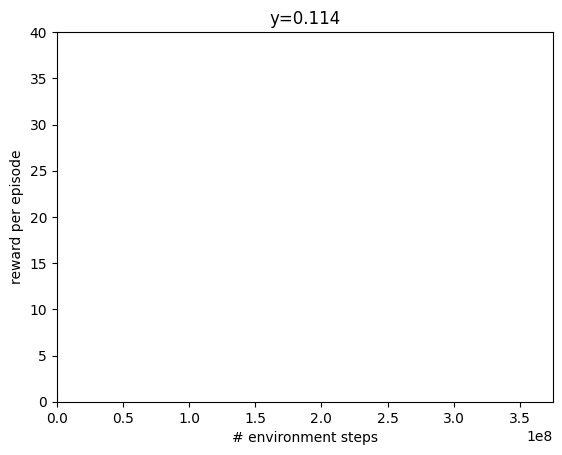

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated a

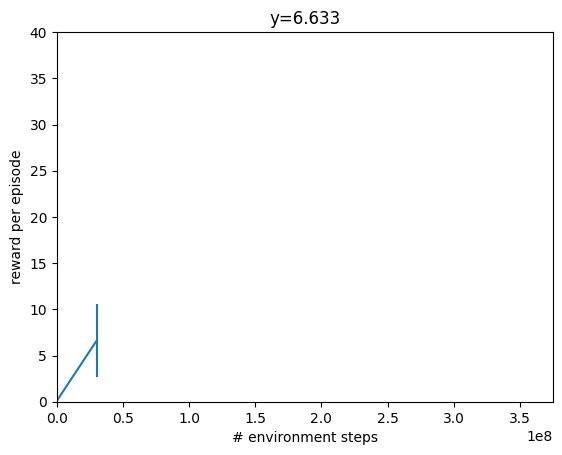

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated a

KeyboardInterrupt: 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/usr/local/lib/python3.12/dist-packages/google/protobuf/internal/well_known_types.py:178: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [39]:
from datetime import datetime
from pupperv3_mjx import utils
import importlib

importlib.reload(utils)

train_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

ENTITY = None
wandb.init(entity=ENTITY,
           project="Wheeled_Pupper",
           name=run_name,
           config=CONFIG.to_dict(),
           save_code=True,
           settings={
           "_service_wait": 90,
           "init_timeout": 90})

try:
    wandb.run.summary["benchmark_physics_steps_per_sec"] = physics_steps_per_sec
except:
    pass

# Save and reload params.
output_folder = f"output_{wandb.run.name}"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create and JIT reset and step functions for use in in-training policy
# video creation if they don't already exist from a previous step
if ("jit_reset" in globals() or "jit_reset" in locals()) and (
    "jit_step" in globals() or "jit_step" in locals()
):
    print("JIT'd step and reset functions already defined. " "Using them for policy visualization.")
else:
    print("Creating and JIT'ing step and reset functions")
    policy_viz_env = envs.get_environment(env_name, **env_kwargs)
    jit_reset = jax.jit(policy_viz_env.reset)
    jit_step = jax.jit(policy_viz_env.step)


make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
    policy_hidden_layer_sizes=CONFIG.policy.hidden_layer_sizes,
    activation=utils.activation_fn_map(CONFIG.policy.activation)
)
train_fn = functools.partial(
    ppo.train,
    **(CONFIG.training.ppo.to_dict()),
    network_factory=make_networks_factory,
    randomization_fn=functools.partial(
        domain_randomization.domain_randomize,
        friction_range=CONFIG.training.friction_range,
        kp_multiplier_range=CONFIG.training.position_control_kp_multiplier_range,
        kd_multiplier_range=CONFIG.training.position_control_kd_multiplier_range,
        body_com_x_shift_range=CONFIG.training.body_com_x_shift_range,
        body_com_y_shift_range=CONFIG.training.body_com_y_shift_range,
        body_com_z_shift_range=CONFIG.training.body_com_z_shift_range,
        body_mass_scale_range=CONFIG.training.body_mass_scale_range,
        body_inertia_scale_range=CONFIG.training.body_inertia_scale_range,
    ),
    seed=28,
)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

env = envs.get_environment(env_name, **env_kwargs)
eval_env = envs.get_environment(env_name, **env_kwargs)

def policy_params_fn(current_step, make_policy, params):
    utils.visualize_policy(current_step=current_step,
                           make_policy=make_policy,
                           params=params,
                           eval_env=eval_env,
                           jit_step=jit_step,
                           jit_reset=jit_reset,
                           output_folder=output_folder)
    utils.save_checkpoint(current_step=current_step,
                          make_policy=make_policy,
                          params=params,
                          checkpoint_path=output_folder)

from pathlib import Path
checkpoint_kwargs = {}
if CONFIG.training.checkpoint_run_number is not None:
  utils.download_checkpoint(entity_name=ENTITY,
                            project_name="pupperv3-mjx-rl",
                            run_number=CONFIG.training.checkpoint_run_number,
                            save_path="checkpoint")
  checkpoint_kwargs["restore_checkpoint_path"]=Path("checkpoint").resolve()

make_inference_fn, params, _ = train_fn(
    environment=env,
    progress_fn=functools.partial(
        utils.progress,
        times=times,
        x_data=x_data,
        y_data=y_data,
        ydataerr=ydataerr,
        num_timesteps=CONFIG.training.ppo.num_timesteps,
        min_y=0,
        max_y=40,
    ),
    eval_env=eval_env,
    policy_params_fn=policy_params_fn,
    **checkpoint_kwargs
)

print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")
wandb.run.summary["time_to_jit"] = (times[1] - times[0]).total_seconds()
wandb.run.summary["time_to_train"] = (times[-1] - times[1]).total_seconds()

In [ ]:
model_path = os.path.join(output_folder, f'mjx_params_{train_datetime}')
model.save_params(model_path, params)
# params = model.load_params(model_path)

In [ ]:
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

# Visualize Policy

For the Barkour Quadruped, the joystick commands can be set through `x_vel`, `y_vel`, and `ang_vel`. `x_vel` and `y_vel` define the linear forward and sideways velocities with respect to the quadruped torso. `ang_vel` defines the angular velocity of the torso in the z direction.

In [ ]:
eval_env = envs.get_environment(env_name, **env_kwargs)

In [ ]:
# @markdown Commands **only used for Pupper Env**:
x_vel = 0.75  #@param {type: "number"}
y_vel = -0.0  #@param {type: "number"}
ang_vel = 0.0  #@param {type: "number"}
pitch_degs = 0 #@param {type: "number"}

the_command = jp.array([x_vel, y_vel, ang_vel])

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
state.info['command'] = the_command
pitch_rad = pitch_degs * 3.14/180.0
state.info['desired_world_z_in_body_frame'] = jp.array([jp.sin(pitch_rad),
                                                        0.0,
                                                        jp.cos(pitch_rad)])
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 200
render_every = 2
ctrls = []

for i in range(n_steps):
  act_rng, rng = jax.random.split(rng)

  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)
  ctrls.append(ctrl)

media.show_video(
    eval_env.render(rollout[::render_every], camera='tracking_cam'),
    fps=1.0 / eval_env.dt / render_every)

In [ ]:
import numpy as np
from pupperv3_mjx import plotting
plotting.plot_multi_series(data=np.array(ctrls), dt=0.02, display_axes=[0,1,2], title="Policy output")

In [ ]:
torques = jp.array([rollout[i].qfrc_actuator[6:] for i in range(len(rollout))]) # ignore world-body joint
plotting.plot_multi_series(data=torques, dt=0.02, display_axes=[0, 1, 2], title="Joint torques")

In [ ]:
joint_pos = jp.array([rollout[i].q[7:] for i in range(len(rollout))]) # ignore world-body joint
plotting.plot_multi_series(data=joint_pos, dt=0.02, display_axes=[0, 1, 2], title="Joint Positions")

In [ ]:
world_vel = jp.array([rollout[i].qvel[:3] for i in range(len(rollout))])
plotting.plot_multi_series(data=world_vel, dt=0.02, display_axes=[0, 1, 2], title="World Velocity")

We can also render the rollout using the Brax renderer.

In [ ]:
# HTML(html.render(eval_env.sys.replace(dt=eval_env.dt), rollout))
# something removed changed in the api
# HTML(html.render(eval_env.sys, rollout))

# Export Policy for neural_controller

After running the following cells, open the files tab on the left and download policy.json.

In [ ]:
import json
from pupperv3_mjx import export
params_rtneural = export.convert_params(jax.block_until_ready(params),
                                        activation=CONFIG.policy.activation,
                                        action_scale=CONFIG.policy.action_scale,
                                        kp=CONFIG.training.position_control_kp,
                                        kd=CONFIG.training.dof_damping,
                                        default_pose=CONFIG.training.default_pose,
                                        joint_upper_limits=CONFIG.simulation.joint_upper_limits,
                                        joint_lower_limits=CONFIG.simulation.joint_lower_limits,
                                        use_imu=CONFIG.policy.use_imu,
                                        observation_history=CONFIG.policy.observation_history,
                                        maximum_pitch_command=CONFIG.training.maximum_pitch_command,
                                        maximum_roll_command=CONFIG.training.maximum_roll_command,
                                        final_activation="tanh",
                                        )

name = f"policy_{wandb.run.name}_max_reward_{y_data[-1]:0.2f}.json"
saved_policy_filename = os.path.join(output_folder, name)
with open(saved_policy_filename, "w") as f:
  json.dump(params_rtneural, f)

wandb.log_model(path=saved_policy_filename, name=name)
wandb.log_model(path=model_path, name=f"mjx_policy_network_{wandb.run.name}.pt")
wandb.finish()

# Shutdown the runtime to save money

In [ ]:
# Give time for wandb to actually finish?
import time
time.sleep(10)

# Helpful for overnight runs
from google.colab import runtime
runtime.unassign()

# Authors
Google, Nathan, Gabrael